# Try to search on one galactic binary source

We use the LDC toolbox +:

- samplermcmc: 
  - `git clone -b mgPTMCMC https://gitlab.in2p3.fr/stas/samplermcmc`
  - `python setup.py install`
- corner: `pip install corner`
- acor: `pip install acor`

In [1]:
import numpy as np
import sys, os
from collections import defaultdict
import corner

import ldc.io.hdf5 as h5io
from ldc.common.series import TDI, FrequencySeries, TimeSeries
from ldc.waveform.fastGB import FastGB
from ldc.lisa.orbits import Orbits
from ldc.common.tools import window
from ldc.lisa.noise import AnalyticNoise
import lisaconstants as constants

import MCMC_multichain.ptMCMC_multichain as ptmcmc

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

%load_ext autoreload
%autoreload 2

## Loading the first 7 months of data in frequency domain

In [2]:
sangria_fn = "LDC2_sangria_training_v2.h5"
cfg = h5io.load_config(sangria_fn, "obs/config")

In [3]:
cfg

{'accnoise': 2.4e-15,
 'backlinknoise': 3e-12,
 'dirname': 'v2',
 'dt': <Quantity 2.5 s>,
 'dt_instrument': <Quantity 0.25 s>,
 'dt_orbits': <Quantity 86400. s>,
 'dt_tdi': <Quantity 5. s>,
 'initial_position': <Quantity 0. rad>,
 'initial_rotation': <Quantity 0. rad>,
 'interp_order': 9,
 'nbatch': 1,
 'nominal_arm_length': <Quantity 2.5e+09 m>,
 'orbit_type': 'equal_armlength',
 'physic_upsampling': 1,
 'readoutnoise': 6.35e-12,
 'sim_kaiser_attenuation': 240,
 'sim_kaiser_delay': 4.5,
 'sim_kaiser_passband': 1.1,
 'sim_kaiser_stopband': 2.9,
 't_max': <Quantity 31536000. s>,
 't_min': <Quantity 0. s>,
 'tdi_kaiser_attenuation': 240,
 'tdi_kaiser_cutoff': 0.05,
 'tdi_kaiser_delay': 161.75,
 'tdi_kaiser_passband': 0.05,
 'tdi_kaiser_stopband': 0.1,
 'travel_time_order': 1}

In [4]:
AET_data = TDI.load(sangria_fn, "obs/tdi") 
#AET_data = TDI.load(sangria_fn, "sky/dgb/tdi") #could try noise free data 
AET_data.XYZ2AET()

dt = AET_data.A.attrs['dt']
t_max = (AET_data.t[-1]+dt)/12*7 # reduce to 7 months
t_max = (t_max//dt)*dt
AET_data = AET_data.sel(t=slice(0, t_max-dt))
t0 = AET_data.t[0]
AET_data = TDI(dict(zip(AET_data.keys(), 
                        [AET_data[k].ts.fft(win=window) for k in AET_data.keys()])))

### Select a small frequency bin with one source

In [5]:
cat, units = h5io.load_array(sangria_fn, "sky/dgb/cat")
fr_my_min = 10.062e-3
fr_my_max = 10.085e-3
selec = (cat["Frequency"]>fr_my_min) & (cat['Frequency']<fr_my_max) 
print(f"Select {selec.sum()} source")

Select 1 source


### Generate it's true waveform using FastGB

In [6]:
from ldc.lisa.orbits import Orbits
orbits = Orbits.type(dict({'orbit_type':'analytic', 'nominal_arm_length':cfg['nominal_arm_length'],
                           "initial_position": 0, "initial_rotation": 0}))
GB = FastGB(delta_t=dt, T=t_max)#, orbits=orbits)
src = dict(zip(cat.dtype.names, cat[selec][0])) # make a dict of that single source
src.pop('Name'); del cat;
X,Y,Z = GB.get_fd_tdixyz(template=src, oversample=4)
AET_fast = TDI(dict(zip(["X", "Y", "Z"], [X, Y, Z])))
AET_fast.XYZ2AET() 

In [71]:
dt

15

### Replace data with a single source noise free TDI

In [143]:
#from ldc.waveform.waveform import HpHc
#from ldc.lisa.projection import ProjectedStrain

# h+, hx
#GW = HpHc.type("debug", "GB", "TD_fdot"); GW.set_param(src)
#p = ProjectedStrain(orbits)
#yArm = p.arm_response(0, t_max, dt, [GW])

#p.to_file("y.h5")
#p.from_file("dgb-y-15.h5")
#yArm0 = p.yArm.copy()
#yArm = p.arm_response(0, yArm0.shape[0]*dt, dt, [GW])

#X = TimeSeries(p.compute_tdi_x(np.arange(0, t_max, dt)), dt=dt, t0=0)
#Y = TimeSeries(p.compute_tdi_y(np.arange(0, t_max, dt)), dt=dt, t0=0)
#Z = TimeSeries(p.compute_tdi_z(np.arange(0, t_max, dt)), dt=dt, t0=0)
#X = X.ts.fft(win=window); Y = Y.ts.fft(win=window);Z = Z.ts.fft(win=window)
#AET_data = TDI(dict(zip(["X", "Y", "Z"], [X,Y,Z])))
#AET_data.XYZ2AET()

### Get a noise model

In [7]:
acc = cfg['accnoise']**2
oms = (cfg['backlinknoise'] + cfg['readoutnoise'])**2
noise = AnalyticNoise(AET_data.f, model="custom", wd=0, oms=oms, acc=acc)

/home/maude/pv39/lib/python3.9/site-packages/ldc-0.1-py3.9-linux-x86_64.egg/ldc/lisa/noise/noise.py:225: RuntimeWarning: divide by zero encountered in true_divide
  Sa_a = AnalyticNoise.DSa_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/home/maude/pv39/lib/python3.9/site-packages/ldc-0.1-py3.9-linux-x86_64.egg/ldc/lisa/noise/noise.py:227: RuntimeWarning: divide by zero encountered in power
  self.Sa_d = Sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/home/maude/pv39/lib/python3.9/site-packages/ldc-0.1-py3.9-linux-x86_64.egg/ldc/lisa/noise/noise.py:228: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = self.Sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/home/maude/pv39/lib/python3.9/site-packages/ldc-0.1-py3.9-linux-x86_64.egg/ldc/lisa/noise/noise.py:232: RuntimeWarning: divide by zero encountered in true_divide
  self.Soms_d = AnalyticNoise.DSoms_d[self.model] * (1. + (2.e-3/frq)**4) # in displacement
/home/maude/pv39/lib/python3.9/site-packages/ldc-0.1-py3.9-linux-x86_64.e

(1e-05, 0.16817928305074292, 1e-43, 1.408172218876628e-37)

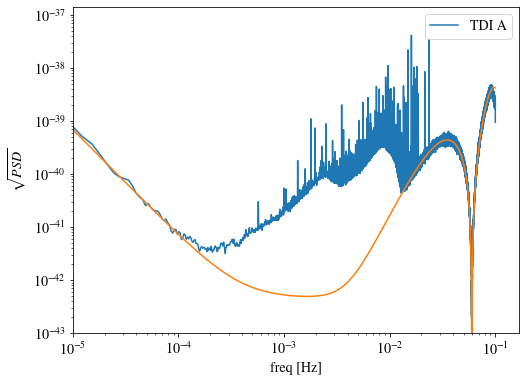

In [9]:
import scipy
T = TDI.load(sangria_fn, "obs/tdi") 
T.XYZ2AET()
T = T.sel(t=slice(0, t_max-dt))
f, psdA = scipy.signal.welch(T["A"], fs=1.0/dt, window='hanning', nperseg=256*256)
noise = AnalyticNoise(AET_data.f, model="oups", wd=0, oms=0.7*oms, acc=acc)
plt.figure(figsize=(8,6))
plt.loglog(f, psdA, label="TDI A")
psdN = noise.psd(option='A', freq=f)
plt.loglog(f, psdN)
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("$\sqrt{PSD}$")
plt.axis([1e-5, None, 1e-43, None])

## Define likelihood and priors

In [10]:
def make_prior(f_fctr=1.e-3):
    Amp_bnd = [-24.0, -20.0] ### log10 amplitude
    fr_bnd = np.array([fr_my_min, fr_my_max])   ### in Hz
    fdot_bnd = [-17.0, -14.0]  ### log10 fdot
    sin_bet_bnd = [-1.0, 1.0]
    lam_bnd = [0.0, 2.0*np.pi]
    cos_iota_bnd = [-1.0, 1.0]
    psi_bnd = [0.0, 2.0*np.pi]
    phi0_bnd = [0.0, 2.0*np.pi]
    prior = [Amp_bnd, fr_bnd, fdot_bnd, sin_bet_bnd, lam_bnd, cos_iota_bnd, psi_bnd, phi0_bnd]
    prior = np.array(prior)
    return (prior)

prior = make_prior()
prior_sky_V = 4.*np.pi 
prior_incl = 2.0
prior_psi = np.pi
prior_phi = np.pi
prior_f = int((fr_my_max - fr_my_min)*t_max)
prior_fdot = int((10**prior[2][1] - 10**prior[2][0])*t_max*t_max)
prior_vol = [prior_sky_V, prior_incl, prior_psi, prior_phi, prior_f, prior_fdot]
print ('prior vol', prior_vol)
logPi = 0.0
for pri in prior_vol:
    logPi = logPi - np.log(pri)
print ('log prior per source', logPi)    
def log_prior(x):
    return logPi

prior vol [12.566370614359172, 2.0, 3.141592653589793, 3.141592653589793, 423, 3]
log prior per source -12.659615666942424


In [11]:
Npars = len(src)

def is_in_prior(pp):
    inPrior = True
    for i in range(len(pp)):
        if (pp[i]<prior[i,0] or pp[i]>prior[i,1]):
            inPrior = False
    return inPrior

def as_search_param(pp):
    """ Switch from fastGB parameterizatoin to search parameterization
    """
    Amp = pp['Amplitude']
    f0 = pp['Frequency']
    fdot = pp['FrequencyDerivative']
    bet, lam = pp["EclipticLatitude"], pp["EclipticLongitude"]
    iota = pp["Inclination"]
    psi, phi0 = pp["Polarization"], pp['InitialPhase']
    return np.array([np.log10(Amp), f0, np.log10(fdot), np.sin(bet), lam, np.cos(iota), psi, phi0])
            
def as_gb_param(pp):
    """ switch from search parameterization to fastGB parameterization
    """
    l_Amp, mf0, l_fdot, sin_bet, lam, cos_iota, psi, phi0 = pp
    iota = np.arccos(cos_iota)
    beta = np.arcsin(sin_bet)
    amp = 10.0**l_Amp
    f0 = mf0 
    fdot = 10.0**l_fdot
    return {'Frequency':f0, 'FrequencyDerivative':fdot, 'EclipticLatitude':beta, 'EclipticLongitude':lam, 
            'Amplitude':amp, 'Inclination':iota, 'Polarization':psi, 'InitialPhase':phi0}

def likelihood_flat(pars, plotIt=False):
    """ pars is Nsrc x Npars
    """    
    Nsrc = int(len(pars)/Npars) ## number of sources in the model 
    pars = np.reshape(pars, (Nsrc, Npars))
    
    for ind in range(Nsrc):
        pp = pars[ind, :]
        inPrior = is_in_prior(pp)
        if not inPrior:
            return -np.inf
        
        pGB = as_gb_param(pp)
        Xf_i, Yf_i, Zf_i = GB.get_fd_tdixyz(template=pGB, oversample=4)
        
        if ind == 0:
            Xf, Yf, Zf = Xf_i.copy(), Yf_i.copy(), Zf_i.copy()
        else:
            Xf += Xf_i ; Yf += Yf_i ; Zf += Zf_i
        
    AET = TDI(dict(zip(["X", "Y", "Z"], [Xf, Yf, Zf])))
    AET.XYZ2AET()
    df = (AET.f[1]-AET.f[0]).values
    SA = noise.psd(freq=AET.f, option='A')
    kmin = int(AET.A.attrs["kmin"])
    At = AET_data.A.values[kmin:kmin+len(AET.A.values)]
    Et = AET_data.E.values[kmin:kmin+len(AET.A.values)]
    
    SNR2 = np.sum( np.real(At * np.conjugate(AET.A.values) +\
                           Et * np.conjugate(AET.E.values)) /SA )
    hh = np.sum((np.absolute(AET.A)**2 + np.absolute(AET.E)**2) /SA)
    
    if plotIt:
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,8)) 
        ax[0].plot(AET.f, np.abs(At), label='data')
        ax[0].plot(AET.f, np.abs(AET.A), label='model')
        ax[1].plot(AET.f, np.abs(Et), label='data')
        ax[1].plot(AET.f, np.abs(AET.E), label='model')
        for i in range(2):
            ax[i].set_xlim([10.065e-3, 10.071e-3])
            ax[i].set_ylim([1.e-18, 1.5e-16])
            ax[i].legend(); 
        plt.show()
        
    loglik = 4.0*df*( SNR2 - 0.5 * hh )
    return (loglik.values) 


### Evaluate likelihood at true value

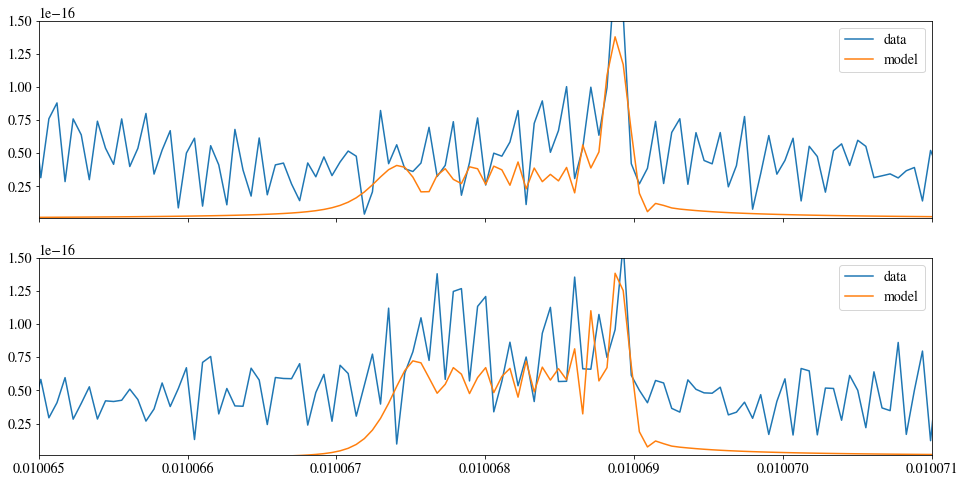

Likelihood at true value is 1548.5504946666251


In [12]:
pars = as_search_param(src)
l0 = likelihood_flat(pars, plotIt=True)
print(f'Likelihood at true value is {l0}')

### Check that likelihood is max at true value

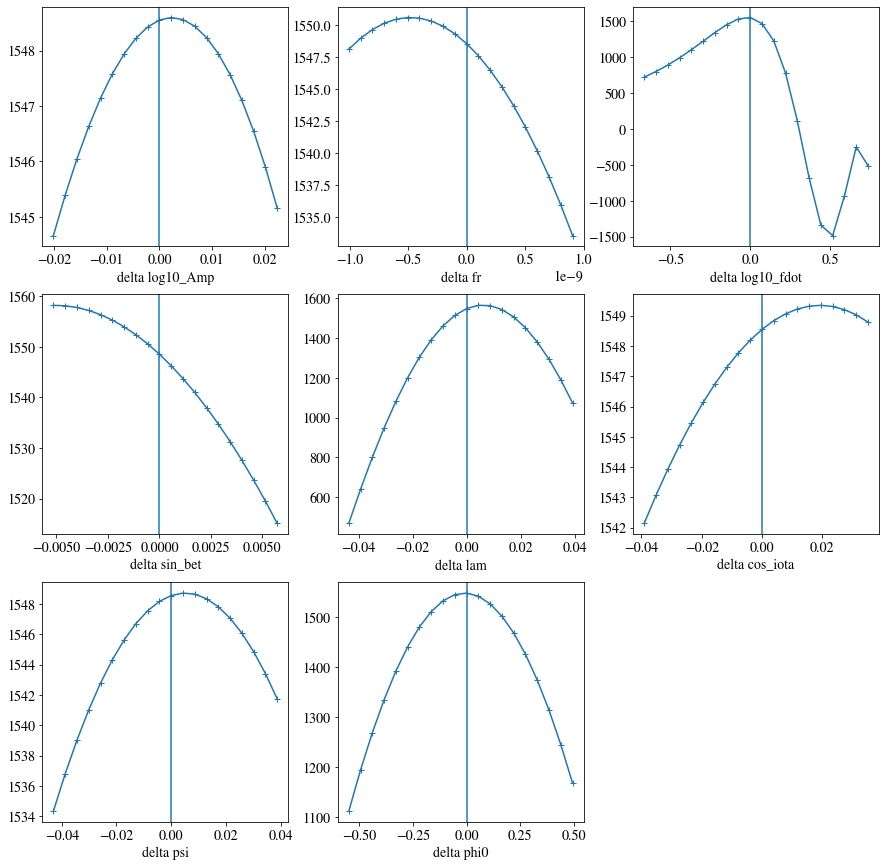

In [13]:
plt.figure(figsize=(15,15))
lbls = ['log10_Amp', 'fr', 'log10_fdot', 'sin_bet', 'lam', 'cos_iota', 'psi', 'phi0'] 
#for i_param, precision in [(0, 0.05), (1, 1e-7), (2, 5e-1), (3, 1e-2), (4, 1e-2), 
#                           (5, 5e-2),  (6, 1e-1), (7, 1e0)]:
for i_param, precision in [(0, 0.01), (1, 1e-6), (2, 5e-1), (3, 1e-1), (4, 1e-1), 
                           (5, 5e-1),  (6, 1e0), (7, 1e0)]:
    deltas = []
    lls = []
    for idelta in range(-10, 10):
        delta = pars[i_param]*idelta*precision/100. #-1 to 1%
        deltas.append(delta)
        p_ = pars.copy()
        p_[i_param] += delta
        ll = likelihood_flat(p_)
        lls.append(ll)

    plt.subplot(3,3,i_param+1)
    plt.plot(deltas, lls, marker='+')
    plt.xlabel("delta "+lbls[i_param])
    plt.axvline(x=0)

### Start the search from a random point

In [14]:
def random_point(prior):
    sz = np.shape(prior)[0]
    p = np.random.random(sz)
    for i in range(sz):
        p[i] = p[i]*(prior[i,1] - prior[i,0]) + prior[i,0]
    return p

x01 = random_point(prior)
print ('random point from prior: loglik =', likelihood_flat(x01))

random point from prior: loglik = -97.31803844166376


### Chain settings

In [15]:
Tmax = 30.0  ### max temperature
Nchains = 5   ### number of chains
nsrcs = 1
Nadapt = 1000
arg_harm= {'maxoff':8.0}
prop_args = {'cov' : None, 'DE_skip': 1000, 'num_modes': 10}
out_dir = '.'
nm_pars1 = ['log10_Amp', 'fr', 'log10_fdot', 'sin_bet', 'lam', 'cos_iota', 'psi', 'phi0'] 
logpi = log_prior(None)

Ms = ptmcmc.aptMCMC(np.array(prior), Nchains, likelihood_flat, log_prior,  Nadapt, nm_pars1, 
                    adapt_t0=1.e7, adapt_nu=1.e6, Nthreads=1) 
Ms.SetTemperatures(Tmax=Tmax, nTemp=None)
print ("we'll use", Ms.GetNumChains(), "chains")

### initialize the chains:
x1 = []
for ic in range(Nchains):
    x1.append(random_point(prior)) 
Ms.InitialPoints(x1)

### proposals for each chain
prop_dics = [{'ReMHA':10., 'SCAM':40., 'DE':50, 'slice':30., 'harmonicShift':10},\
            {'ReMHA':10., 'SCAM':40., 'DE':50., 'slice':30., 'harmonicShift':10},\
            {'ReMHA':10., 'SCAM':40., 'DE':50., 'slice':30., 'harmonicShift':10},\
            {'SCAM':70., 'DE':50., 'slice':40., 'harmonicShift':10},\
            {'SCAM':70., 'DE':50., 'DE_all':10, 'slice':40., 'harmonicShift':10}]
Ms.InitializeProposals(prop_dics , **prop_args)

### add a custom proposal
def my_harmonicShift(x, par_dict, **kwargs):
    """
    TODO: so far will work only for one source
    hardcode position of freq in the parameters
    """
    qxy = 0.
    YRSID_SI = constants.SIDEREALYEAR_J2000DAY*24*60*60
    df1 = 1.0/YRSID_SI
    y = np.copy(x)
    d = defaultdict(list)
    for i,nm in enumerate(par_dict):
        d[nm].append(i)
    ind = d['fr']
    i = np.random.choice(ind)
    fctr = int( 4.0*np.random.normal(0.0, 1.0))
    if fctr == 0:
        fctr = 1
    sgn = 1.0
    if (np.random.random()<0.5):
        sgn = -1.0
    y[i] = x[i] + sgn*fctr*df1
    return y, qxy, None

Ms.AddProposal('harmonicShift', my_harmonicShift, **arg_harm)

initial temp step 2.340347319320716 8 30.0
range of temperature: [ 1.          2.34034732  5.47722558 12.81861019 30.        ]
we'll use 5 chains


### Run MCMC 

In [184]:
chains = Ms.runMCMC(50000, pSwap=0.95, verbal=True, printN=2000, verbal_all=False) #50000

  0%|          | 0/50000 [00:00<?, ?it/s]

0 current loglik 160.09109313422775 best 162.79188555427552 temp 1.0
1 current loglik 76.86264445430716 best 86.17065282194953 temp 2.340347319320716
2 current loglik 327.93934271617684 best 332.57036349819765 temp 5.47722557505166
3 current loglik 101.631874045449 best 114.80202537803551 temp 12.818610191887018
4 current loglik 4.404273017165102 best 97.38970213180092 temp 29.999999999999993


  4%|▍         | 2001/50000 [32:41<11:40:14,  1.14it/s]

0 current loglik 270.86221277067654 best 271.0528919597544 temp 1.0
1 current loglik 208.10767733345295 best 215.17620281361835 temp 2.340347319320716
2 current loglik 431.7829596977959 best 435.41663018616833 temp 5.47722557505166
3 current loglik 146.63625359798056 best 156.36386436206087 temp 12.818610191887018
4 current loglik 166.79124511084274 best 175.80584187995635 temp 29.999999999999993


  8%|▊         | 4002/50000 [54:54<3:07:15,  4.09it/s] 

0 current loglik 439.2788695161833 best 440.9708061724423 temp 1.0
1 current loglik 362.4129717637479 best 366.0138113003382 temp 2.340359410943595
2 current loglik 308.80632750593776 best 439.3736172048793 temp 5.477452645344451
3 current loglik 230.67486791187525 best 237.7269160524821 temp 12.818761546123303
4 current loglik -31.240896927432342 best 251.99140333962978 temp 30.0


 12%|█▏        | 6001/50000 [1:09:24<3:28:25,  3.52it/s] 

0 current loglik 1023.8560709090407 best 1023.8560709090407 temp 1.0
1 current loglik 633.5114980419737 best 633.622242460857 temp 2.340361666476074
2 current loglik 411.5566539225298 best 441.68534291293474 temp 5.477662568461671
3 current loglik 352.2856053720605 best 416.608080333114 temp 12.819369932136356
4 current loglik 4.748033935715153 best 251.99140333962978 temp 30.0


 16%|█▌        | 8003/50000 [1:16:02<1:21:06,  8.63it/s] 

0 current loglik 1428.9101280388645 best 1433.9783628755577 temp 1.0
1 current loglik 658.307297587122 best 663.9237510652796 temp 2.340363043440858
2 current loglik 447.43980110428515 best 465.5294826427001 temp 5.478145817100649
3 current loglik 374.7395328233384 best 437.5835480799413 temp 12.81969580832465
4 current loglik -0.4603278334849317 best 251.99140333962978 temp 29.999677287948302


 20%|██        | 10003/50000 [1:21:31<1:27:14,  7.64it/s]

0 current loglik 1549.7380081052884 best 1549.7380081052884 temp 1.0
1 current loglik 671.1439684496131 best 673.4448459334318 temp 2.3403639472604167
2 current loglik 442.9604312308302 best 465.68193970062407 temp 5.4784630543900406
3 current loglik 354.1705036556638 best 437.5835480799413 temp 12.82004001105951
4 current loglik -13.032480448566393 best 251.99140333962978 temp 29.99864941984748


 23%|██▎       | 11333/50000 [1:25:08<1:47:21,  6.00it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

 24%|██▍       | 12001/50000 [1:27:17<1:30:41,  6.98it/s] 

0 current loglik 1612.562246147981 best 1613.3745740791396 temp 1.0
1 current loglik 668.9988958746707 best 677.5070390872885 temp 2.3403646207522915
2 current loglik 442.35165144160777 best 469.4843012835543 temp 5.47869946811408
3 current loglik 389.4830196945154 best 441.0875182715435 temp 12.820322435203535
4 current loglik 3.631518573818057 best 251.99140333962978 temp 29.99784885037798


 25%|██▍       | 12332/50000 [1:28:18<4:32:54,  2.30it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 27%|██▋       | 13333/50000 [1:31:21<2:02:06,  5.00it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 27%|██▋       | 13449/50000 [1:31:41<1:22:50,  7.35it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max

0 current loglik 1612.457272870039 best 1613.9057386702702 temp 1.0
1 current loglik 671.9714685974419 best 677.5070390872885 temp 2.34036515755199
2 current loglik 458.55690477434575 best 469.4843012835543 temp 5.478887911809801
3 current loglik 318.373221250014 best 441.0875182715435 temp 12.82106337399673
4 current loglik -10.481846119370276 best 251.99140333962978 temp 29.99651984181245


 29%|██▉       | 14449/50000 [1:34:45<1:31:43,  6.46it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did no

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 29%|██▉       | 14497/50000 [1:35:02<1:59:35,  4.95it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did no

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max

0 current loglik 1607.4501733226728 best 1613.9057386702702 temp 1.0
1 current loglik 666.5750764053943 best 678.684012777701 temp 2.3403656054277677
2 current loglik 442.3786611593659 best 469.4843012835543 temp 5.479045147286296
3 current loglik 372.24451408863507 best 447.998265416818 temp 12.821863912689288
4 current loglik 1.2235355234883667 best 251.99140333962978 temp 29.995167211654866


 33%|███▎      | 16449/50000 [1:40:50<1:21:59,  6.82it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 35%|███▍      | 17497/50000 [1:43:54<1:35:58,  5.64it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did no

0 current loglik 1610.2647762131207 best 1613.9057386702702 temp 1.0
1 current loglik 675.9692150778568 best 678.684012777701 temp 2.340365988337478
2 current loglik 462.6928022283345 best 469.60797217155505 temp 5.479179581333463
3 current loglik 388.5523753467052 best 467.35613298970696 temp 12.822632131861642
4 current loglik 367.26920112000136 best 447.6565071366438 temp 29.993957370544635


 37%|███▋      | 18449/50000 [1:46:53<1:18:02,  6.74it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 39%|███▉      | 19449/50000 [1:50:21<1:28:55,  5.73it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1612.860700296261 best 1613.9057386702702 temp 1.0
1 current loglik 1596.0543808802222 best 1612.7941840910812 temp 2.340381756594952
2 current loglik 652.8900915923368 best 673.5959003737008 temp 5.479276578654016
3 current loglik 504.6197597755887 best 523.8100864453227 temp 12.824012808630144
4 current loglik 391.8326940170465 best 1440.3207921188362 temp 29.993594280567393


 41%|████      | 20449/50000 [1:54:00<1:42:51,  4.79it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 44%|████▍     | 22001/50000 [1:59:45<1:38:09,  4.75it/s]

0 current loglik 1612.3369174035352 best 1613.9057386702702 temp 1.0
1 current loglik 1609.5476824548837 best 1613.4211818886527 temp 2.340613501849911
2 current loglik 688.8037621494392 best 702.5577525090749 temp 5.4790711847808
3 current loglik 633.9252023636045 best 701.3747330127079 temp 12.825340321780367
4 current loglik 486.57998834298945 best 1440.3207921188362 temp 29.99330584999339


 45%|████▍     | 22449/50000 [2:01:14<1:19:54,  5.75it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 45%|████▍     | 22497/50000 [2:01:25<1:27:16,  5.25it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1612.6759565622156 best 1613.9057386702702 temp 1.0
1 current loglik 1603.2188974790802 best 1613.4211818886527 temp 2.3411957359151128
2 current loglik 707.5022209536897 best 722.492144901708 temp 5.478385427756058
3 current loglik 635.4514969783771 best 701.3747330127079 temp 12.82664089127438
4 current loglik 530.7915538912292 best 1440.3207921188362 temp 29.99369972497194


 49%|████▉     | 24448/50000 [2:07:34<1:18:54,  5.40it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 51%|█████     | 25448/50000 [2:11:04<1:04:05,  6.38it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1610.3288671623447 best 1613.9057386702702 temp 1.0
1 current loglik 1604.594346669051 best 1613.4211818886527 temp 2.3418867249764537
2 current loglik 713.9711782142493 best 727.1864097004539 temp 5.477546883534432
3 current loglik 623.4344440746753 best 701.3747330127079 temp 12.827617641322213
4 current loglik 567.5798908140331 best 1440.3207921188362 temp 29.998540208853573


 53%|█████▎    | 26449/50000 [2:14:19<1:00:01,  6.54it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1608.3032799745235 best 1613.9057386702702 temp 1.0
1 current loglik 1605.4089891910046 best 1613.7753733910108 temp 2.3427638049124866
2 current loglik 705.484590324243 best 727.83141485607 temp 5.4764549383316705
3 current loglik 642.9805908109645 best 701.3747330127079 temp 12.828210159685883
4 current loglik 567.8344852682692 best 1440.3207921188362 temp 30.0


 57%|█████▋    | 28333/50000 [2:21:06<56:24,  6.40it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 57%|█████▋    | 28449/50000 [2:21:28<1:03:02,  5.70it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1608.625103045989 best 1613.9057386702702 temp 1.0
1 current loglik 1605.250046466242 best 1613.7753733910108 temp 2.3438618040721453
2 current loglik 1577.6529516110713 best 1580.2726688548353 temp 5.475064952796461
3 current loglik 666.8690236437402 best 703.1432784350737 temp 12.828368377576979
4 current loglik 585.2162881384621 best 1440.3207921188362 temp 30.0


 61%|██████    | 30333/50000 [2:26:45<1:00:05,  5.45it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1611.2024472875983 best 1613.9057386702702 temp 1.0
1 current loglik 1609.1109846586928 best 1613.7753733910108 temp 2.3451650608480152
2 current loglik 1607.3235344776342 best 1611.7953888566997 temp 5.4736650538500795
3 current loglik 1571.9929286575345 best 1609.5366794590589 temp 12.828632094852058
4 current loglik 1540.5058898711143 best 1607.6701790786124 temp 30.0


 65%|██████▍   | 32331/50000 [2:32:25<52:31,  5.61it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 65%|██████▍   | 32448/50000 [2:32:48<44:57,  6.51it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1608.4892262340331 best 1613.9057386702702 temp 1.0
1 current loglik 1606.252503009635 best 1613.7753733910108 temp 2.346630079229328
2 current loglik 1597.4527573550965 best 1611.8102392744593 temp 5.472749313344128
3 current loglik 1582.2104835015339 best 1610.7837118132927 temp 12.829533685061605
4 current loglik 1521.7846469058834 best 1607.6701790786124 temp 30.0


 69%|██████▉   | 34449/50000 [2:39:10<43:15,  5.99it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1611.3309433233999 best 1613.9057386702702 temp 1.0
1 current loglik 1610.612148310589 best 1613.7753733910108 temp 2.348260206919875
2 current loglik 1602.7657717301515 best 1611.8102392744593 temp 5.4722901979228755
3 current loglik 1603.4322387184893 best 1612.0461279907138 temp 12.830876267380361
4 current loglik 1287.227968625887 best 1607.6701790786124 temp 30.0


 73%|███████▎  | 36449/50000 [2:46:10<54:44,  4.13it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1611.6387787071133 best 1613.9057386702702 temp 1.0
1 current loglik 1605.3952035624282 best 1613.7753733910108 temp 2.3500691175322395
2 current loglik 1602.1675934035325 best 1612.7564688828606 temp 5.472177910179391
3 current loglik 1521.2228689179817 best 1612.0461279907138 temp 12.831957027398722
4 current loglik 1531.3790837899098 best 1607.6701790786124 temp 30.0


 77%|███████▋  | 38333/50000 [2:52:58<34:38,  5.61it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1619.4843901789432 best 1624.25373199863 temp 1.0
1 current loglik 1610.9842788947453 best 1613.7753733910108 temp 2.3519822032194666
2 current loglik 1600.4514014836857 best 1612.7564688828606 temp 5.472521077265586
3 current loglik 1531.6945232710434 best 1612.0461279907138 temp 12.832579084066438


 80%|████████  | 40001/50000 [2:58:11<40:12,  4.14it/s]

4 current loglik 1492.1120438960093 best 1607.6701790786124 temp 30.0


 81%|████████  | 40449/50000 [2:59:33<28:23,  5.61it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 84%|████████▍ | 41998/50000 [3:04:07<24:48,  5.38it/s]  

0 current loglik 1622.9603663096834 best 1624.5748856721113 temp 1.0
1 current loglik 1612.6937563030708 best 1621.5765946569666 temp 2.353814271520582
2 current loglik 1608.8594501331422 best 1612.7564688828606 temp 5.473378850141026
3 current loglik 1572.0534025624593 best 1612.7478336699826 temp 12.833624821628385


 84%|████████▍ | 42001/50000 [3:04:08<23:42,  5.62it/s]

4 current loglik 1599.7904115763445 best 1608.3199386714439 temp 30.0


 85%|████████▍ | 42333/50000 [3:05:06<15:27,  8.27it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not c

0 current loglik 1628.4318514023062 best 1631.4968548448956 temp 1.0
1 current loglik 1606.766966621952 best 1630.8386299555846 temp 2.355654171206468
2 current loglik 1601.9067891750192 best 1627.366245412562 temp 5.474401630145888
3 current loglik 1568.1190843892061 best 1617.7459010232556 temp 12.835247826231527
4 current loglik 1580.096683089151 best 1609.5390673437164 temp 30.0


 89%|████████▊ | 44333/50000 [3:11:16<18:17,  5.16it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1627.9535525962242 best 1632.4798932682208 temp 1.0
1 current loglik 1629.494193712964 best 1631.197081487784 temp 2.357486403191137
2 current loglik 1607.1844191392604 best 1627.366245412562 temp 5.475495940889143
3 current loglik 1564.4484051613808 best 1617.7459010232556 temp 12.837304487103172
4 current loglik 1429.2201811010862 best 1609.5390673437164 temp 30.0


 93%|█████████▎| 46331/50000 [3:17:28<12:33,  4.87it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not c

0 current loglik 1630.8069803981807 best 1632.4798932682208 temp 1.0
1 current loglik 1626.4777397424473 best 1631.826569622582 temp 2.359361788371791
2 current loglik 1605.824443703303 best 1627.366245412562 temp 5.4764509616199994
3 current loglik 1602.3511729906002 best 1618.7800724948772 temp 12.839826697824531
4 current loglik 1502.8967565495627 best 1609.5390673437164 temp 30.0


 97%|█████████▋| 48333/50000 [3:23:54<05:08,  5.40it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 97%|█████████▋| 48448/50000 [3:24:17<04:42,  5.48it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base

statistics


 chain  0
ReMHA 5170 64
SCAM 14457 7174
DE 15983 978
slice 11834 efficiency 0.1451561465054093
harmonicShift 3691 0

 chain  1
ReMHA 5268 98
SCAM 14500 6362
DE 15730 558
slice 12000 efficiency 0.1430529892114204
harmonicShift 3638 0

 chain  2
ReMHA 5408 102
SCAM 14471 4536
DE 15937 447
slice 11932 efficiency 0.12564761383261025
harmonicShift 3622 0

 chain  3
SCAM 21011 4492
DE 13181 138
slice 11856 efficiency 0.1108006317579881
harmonicShift 3036 4

 chain  4
SCAM 19506 5760
DE 12566 166
DE_all 2484 179
slice 11345 efficiency 0.11006975773981043
harmonicShift 2872 614


### Save the chains on disk

In [185]:
import pickle
pickle.dump({'chains':chains}, open('sangria_chains.pkl', 'wb'))

In [ ]:
#import pickle
#chains = pickle.load(open('sangria_nf_chains.pkl', 'rb'))['chains']

### Look at convergence and parameters

Text(0.5, 0, 'iter')

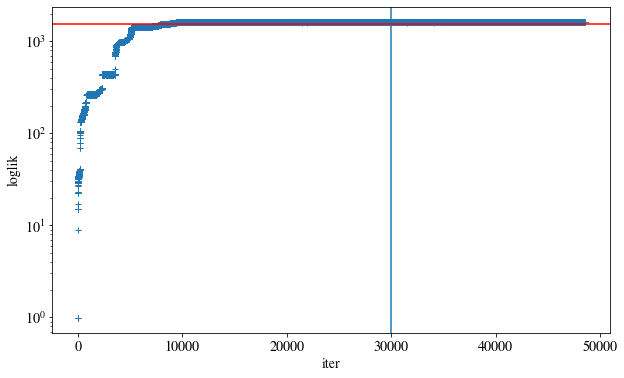

In [192]:
plt.figure(figsize=(10,6))
plt.semilogy(chains[0].logL, ls='None', marker='+')
istart = 30000
plt.axvline(x=istart)
plt.axhline(y=l0, color='r')
plt.ylabel("loglik")
plt.xlabel("iter")

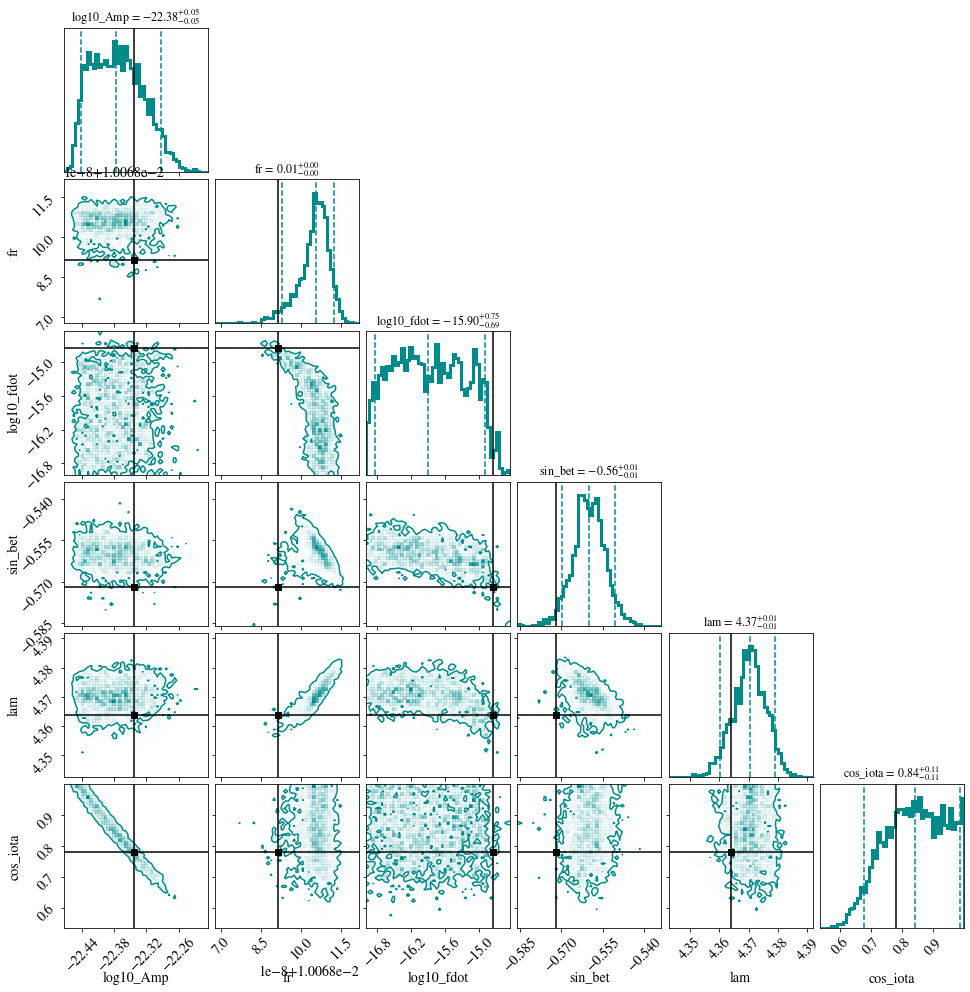

In [102]:
chn_tot = chains[0].chn[istart:]

fig = corner.corner(np.array(chn_tot)[:,:-2],  bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, 
                    color='darkcyan', truths=pars[:-2], truth_color='k', use_math_test=True,
                    levels=[0.9], title_kwargs={"fontsize": 12}, labels=nm_pars1[:-2])

### Look at autocorrelation length

Target is tau $\rightarrow$ 1. 

In [189]:
import acor
for ip in range(8):
    tau, mean, sigma = acor.acor(np.array(chains[0].chn[20000:])[:,ip])
    print(f' param: {nm_pars1[ip]}, tau: {tau}, mean:{mean}, sigma:{sigma}')

 param: log10_Amp, tau: 1720.9293039947006, mean:-22.306660574630783, sigma:0.025487861160489764
 param: fr, tau: 301.64257177512866, mean:0.010068077441453724, sigma:1.385775899233933e-09
 param: log10_fdot, tau: 602.8071438285258, mean:-14.307368380996987, sigma:0.022064628867751433
 param: sin_bet, tau: 806.5109328449579, mean:-0.6181357587079666, sigma:0.0019409348388029668
 param: lam, tau: 185.31675926827495, mean:4.380410424356842, sigma:0.0006529362629125703
 param: cos_iota, tau: 1728.741938121585, mean:0.7590747086344752, sigma:0.052054048426050555
 param: psi, tau: 1713.1936523352051, mean:1.201464331135347, sigma:0.31525366120726583
 param: phi0, tau: 1583.1933368158004, mean:5.259088083365046, sigma:0.1828520805988366


### Trying to go further

Will restart the MCMC where it stopped. 

In [43]:
chains = Ms.runMCMC(50000, pSwap=0.95, verbal=True, printN=2000, verbal_all=False)

  0%|          | 1/50000 [00:00<4:45:42,  2.92it/s]

0 current loglik 1093.6108920381228 best 1095.4174865887653 temp 1.0
1 current loglik 1091.9600286524817 best 1095.2226095266033 temp 2.387056403522002
2 current loglik 1079.814888096326 best 1094.7878832556585 temp 5.540472085353359
3 current loglik 1078.4091324003293 best 1094.6006527676118 temp 12.876085515677115
4 current loglik 1076.509598389098 best 1093.0073309881113 temp 29.88271390199976


  3%|▎         | 1292/50000 [03:41<2:22:02,  5.71it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
  4%|▍         | 2001/50000 [05:48<3:09:43,  4.22it/s]

0 current loglik 1093.1382624866817 best 1095.4174865887653 temp 1.0
1 current loglik 1090.7757281467132 best 1095.2226095266033 temp 2.39038205150636
2 current loglik 1073.7575448050932 best 1094.7878832556585 temp 5.544928530978696
3 current loglik 1067.3620483301693 best 1094.6006527676118 temp 12.878562774784621
4 current loglik 1001.8732796962813 best 1093.0073309881113 temp 29.881666869095312


  4%|▍         | 2193/50000 [06:20<1:41:09,  7.88it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
  6%|▋         | 3240/50000 [09:30<2:43:42,  4.76it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.

0 current loglik 1093.0977190153737 best 1095.4174865887653 temp 1.0
1 current loglik 1086.7629928010815 best 1095.2226095266033 temp 2.3937322822042253
2 current loglik 1094.0320894367192 best 1094.7878832556585 temp 5.549417738517645
3 current loglik 1079.2341059734754 best 1094.6006527676118 temp 12.881361590877459
4 current loglik 1001.2858468712836 best 1093.0073309881113 temp 29.880683999268648


  9%|▊         | 4292/50000 [12:53<1:54:43,  6.64it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not co

0 current loglik 1090.9436354110996 best 1095.4174865887653 temp 1.0
1 current loglik 1089.5188908796538 best 1095.2226095266033 temp 2.397155381768386
2 current loglik 1084.0436302955304 best 1094.7878832556585 temp 5.553930896268338
3 current loglik 1025.5778789284022 best 1094.6006527676118 temp 12.884092318013959
4 current loglik 1018.5202113478315 best 1094.0429169983374 temp 29.879491644041384


 12%|█▏        | 6194/50000 [18:47<2:00:23,  6.06it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 12%|█▏        | 6241/50000 [18:57<2:08:56,  5.66it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.p

0 current loglik 1092.4565508078347 best 1095.4174865887653 temp 1.0
1 current loglik 1090.43956295234 best 1095.2226095266033 temp 2.40062287591635
2 current loglik 1077.0588217516492 best 1094.7878832556585 temp 5.55846310342789
3 current loglik 1048.1755659867795 best 1094.6006527676118 temp 12.886777378911837
4 current loglik 1025.9481533504736 best 1094.0429169983374 temp 29.878620030173195


 16%|█▋        | 8194/50000 [25:06<3:15:16,  3.57it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 17%|█▋        | 8292/50000 [25:24<2:15:02,  5.15it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.p

0 current loglik 1092.5145654395676 best 1095.4174865887653 temp 1.0
1 current loglik 1085.013663077029 best 1095.2226095266033 temp 2.404148444988032
2 current loglik 1084.9778973417751 best 1094.7878832556585 temp 5.563017735572773
3 current loglik 1079.6643840917043 best 1094.6006527676118 temp 12.889374885977208


 20%|██        | 10001/50000 [30:48<2:52:54,  3.86it/s]

4 current loglik 1008.3773363228996 best 1094.0429169983374 temp 29.877851824541406


 21%|██        | 10292/50000 [31:45<2:17:37,  4.81it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 22%|██▏       | 11241/50000 [34:46<2:12:05,  4.89it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_ba

0 current loglik 1093.1867691303598 best 1095.4174865887653 temp 1.0
1 current loglik 1090.5491714222962 best 1095.2226095266033 temp 2.4077142048594076
2 current loglik 1083.9288785968356 best 1094.7878832556585 temp 5.567592171954944
3 current loglik 1016.451771549131 best 1094.6006527676118 temp 12.892016878918191


 24%|██▍       | 12001/50000 [37:05<1:48:17,  5.85it/s]

4 current loglik 1036.9667492878566 best 1094.0429169983374 temp 29.877403251906824


 25%|██▍       | 12291/50000 [38:01<1:56:36,  5.39it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not c

0 current loglik 1091.0957409040884 best 1095.4174865887653 temp 1.0
1 current loglik 1088.7549871842596 best 1095.2226095266033 temp 2.41135348377186
2 current loglik 1086.2166962153424 best 1094.7878832556585 temp 5.572132749310658
3 current loglik 1053.6059572582435 best 1094.6006527676118 temp 12.894565664959618
4 current loglik 1021.3047577473209 best 1094.0429169983374 temp 29.877363766138348


 28%|██▊       | 14194/50000 [44:11<2:25:39,  4.10it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 29%|██▊       | 14292/50000 [44:36<1:19:26,  7.49it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base

0 current loglik 1086.93314162725 best 1095.4174865887653 temp 1.0
1 current loglik 1087.7897913474294 best 1095.2226095266033 temp 2.4150139066269274
2 current loglik 1086.7030822751742 best 1094.7878832556585 temp 5.576747649123835
3 current loglik 1044.9987485609292 best 1094.6006527676118 temp 12.896957433064893


 32%|███▏      | 16001/50000 [49:49<2:23:58,  3.94it/s]

4 current loglik 1058.7468508674272 best 1094.0429169983374 temp 29.87755590675534


 32%|███▏      | 16194/50000 [50:24<1:31:07,  6.18it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 33%|███▎      | 16292/50000 [50:46<1:32:14,  6.09it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base

0 current loglik 1092.771086117649 best 1095.4174865887653 temp 1.0
1 current loglik 1089.082009424904 best 1095.3211707641447 temp 2.4187370938067394
2 current loglik 1086.3549595461095 best 1094.7878832556585 temp 5.58144286201345
3 current loglik 1005.466543681178 best 1094.6006527676118 temp 12.899243038493887


 36%|███▌      | 18001/50000 [56:05<1:47:31,  4.96it/s]

4 current loglik 1055.0139341246818 best 1094.0429169983374 temp 29.87753522803937


 36%|███▋      | 18241/50000 [56:53<1:31:17,  5.80it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 40%|████      | 20000/50000 [1:02:25<1:36:15,  5.19it/s]

0 current loglik 1092.0396322122149 best 1095.4174865887653 temp 1.0
1 current loglik 1081.645863017739 best 1095.3211707641447 temp 2.42247549978595
2 current loglik 1048.0060190138022 best 1094.7878832556585 temp 5.5861648530429004


 40%|████      | 20001/50000 [1:02:25<2:28:19,  3.37it/s]

3 current loglik 1059.575127345262 best 1094.6006527676118 temp 12.901505938647578
4 current loglik 998.1749384025019 best 1094.0429169983374 temp 29.877632295895456


 40%|████      | 20240/50000 [1:03:09<1:15:08,  6.60it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 41%|████      | 20291/50000 [1:03:21<1:56:42,  4.24it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 42%|████▏     | 21241/50000 [1:06:35<2:02:43,  3.91it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/m

0 current loglik 1093.3747976594002 best 1095.4174865887653 temp 1.0
1 current loglik 1086.0467533999522 best 1095.3211707641447 temp 2.4262410561143315
2 current loglik 1090.5791480962769 best 1094.7878832556585 temp 5.590864185356773


 44%|████▍     | 22001/50000 [1:09:10<2:47:36,  2.78it/s]

3 current loglik 1066.4786329322246 best 1094.6006527676118 temp 12.903902255863567
4 current loglik 986.733723192637 best 1094.0429169983374 temp 29.878036171675998


 44%|████▍     | 22194/50000 [1:09:49<2:30:26,  3.08it/s] /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did no

0 current loglik 1092.6654964121146 best 1095.4174865887653 temp 1.0
1 current loglik 1089.3584614068345 best 1095.3211707641447 temp 2.4300133086661555
2 current loglik 1079.4883601394845 best 1094.7878832556585 temp 5.595612855058029
3 current loglik 1076.2809660298117 best 1094.6006527676118 temp 12.906326826196121
4 current loglik 1045.627276711003 best 1094.0429169983374 temp 29.878503780415425


 48%|████▊     | 24193/50000 [1:16:22<1:29:00,  4.83it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 48%|████▊     | 24241/50000 [1:16:34<1:15:46,  5.67it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1092.2631347596657 best 1095.4174865887653 temp 1.0
1 current loglik 1090.3884293615588 best 1095.3211707641447 temp 2.4338333540679375
2 current loglik 1091.3010095852726 best 1094.7878832556585 temp 5.600368734695307


 52%|█████▏    | 26001/50000 [1:22:15<1:53:40,  3.52it/s]

3 current loglik 1012.7933708674899 best 1094.6006527676118 temp 12.908821994731918
4 current loglik 993.7716879778337 best 1094.0429169983374 temp 29.878847129420077


 54%|█████▍    | 27240/50000 [1:26:14<1:05:36,  5.78it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 56%|█████▌    | 28000/50000 [1:28:41<59:49,  6.13it/s]  

0 current loglik 1091.9569261309712 best 1095.4174865887653 temp 1.0
1 current loglik 1091.534181232615 best 1095.3211707641447 temp 2.437693181057899
2 current loglik 1085.3742123903912 best 1094.7878832556585 temp 5.605195888583065


 56%|█████▌    | 28001/50000 [1:28:42<1:37:06,  3.78it/s]

3 current loglik 1068.4732903673244 best 1094.6006527676118 temp 12.91114709096227
4 current loglik 1038.844990679137 best 1094.0429169983374 temp 29.879415122978948


 56%|█████▋    | 28193/50000 [1:29:20<1:02:07,  5.85it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 57%|█████▋    | 28292/50000 [1:29:45<1:10:23,  5.14it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1094.31116370759 best 1095.4174865887653 temp 1.0
1 current loglik 1089.831366522242 best 1095.3211707641447 temp 2.441599503807273
2 current loglik 1083.3811385023184 best 1094.7878832556585 temp 5.610071848732195
3 current loglik 1077.7194953458854 best 1094.6006527676118 temp 12.913363447733486
4 current loglik 991.2342803486811 best 1094.0429169983374 temp 29.880214640309564


 60%|██████    | 30193/50000 [1:36:06<58:09,  5.68it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 61%|██████    | 30292/50000 [1:36:32<56:41,  5.79it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1094.076554924846 best 1095.4174865887653 temp 1.0
1 current loglik 1092.6238286785097 best 1095.3211707641447 temp 2.4455339021421514
2 current loglik 1079.8350786765188 best 1095.2447947729304 temp 5.614995778002784
3 current loglik 1044.4838143302864 best 1094.6006527676118 temp 12.9157456725103
4 current loglik 1051.202215595263 best 1094.0429169983374 temp 29.880851364073123


 64%|██████▍   | 32193/50000 [1:42:50<49:46,  5.96it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 64%|██████▍   | 32240/50000 [1:43:03<1:06:27,  4.45it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1091.1021326443313 best 1095.4174865887653 temp 1.0
1 current loglik 1089.909118472673 best 1095.3211707641447 temp 2.4494954200932417
2 current loglik 1091.0200323221857 best 1095.2447947729304 temp 5.619856911884456
3 current loglik 1040.898654586289 best 1094.6006527676118 temp 12.918166761229273


 68%|██████▊   | 34001/50000 [1:48:37<1:41:11,  2.64it/s]

4 current loglik 978.5115826098743 best 1094.0429169983374 temp 29.881843739799493


 68%|██████▊   | 34193/50000 [1:49:15<50:07,  5.26it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 68%|██████▊   | 34241/50000 [1:49:28<1:10:30,  3.73it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1089.1916603145767 best 1095.4174865887653 temp 1.0
1 current loglik 1093.4291483634183 best 1095.3211707641447 temp 2.4535268810136053
2 current loglik 1077.4323293597756 best 1095.2447947729304 temp 5.624747004256932
3 current loglik 1076.038948242705 best 1094.6006527676118 temp 12.920624386434076
4 current loglik 1017.1470392866423 best 1094.0429169983374 temp 29.88288349034832


 72%|███████▏  | 36194/50000 [1:55:31<37:45,  6.10it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 72%|███████▏  | 36241/50000 [1:55:43<40:42,  5.63it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

 76%|███████▌  | 38000/50000 [2:01:28<1:59:55,  1.67it/s]

0 current loglik 1090.6340638403249 best 1095.4174865887653 temp 1.0
1 current loglik 1085.7485656629024 best 1095.3211707641447 temp 2.457563623115181
2 current loglik 1087.519209558609 best 1095.2447947729304 temp 5.629665475390555
3 current loglik 1075.569546177376 best 1094.6006527676118 temp 12.92308332108318
4 current loglik 953.6235481397422 best 1094.0429169983374 temp 29.883904917944623


 76%|███████▋  | 38193/50000 [2:02:00<26:00,  7.56it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 76%|███████▋  | 38241/50000 [2:02:14<38:01,  5.15it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1089.8272574844448 best 1095.4174865887653 temp 1.0
1 current loglik 1086.5243661669815 best 1095.3211707641447 temp 2.461630070779695
2 current loglik 1089.8264538486312 best 1095.2447947729304 temp 5.634662678874559
3 current loglik 1059.662577153996 best 1094.6006527676118 temp 12.925535855890137
4 current loglik 904.2530928724256 best 1094.0429169983374 temp 29.88423148339728


 80%|████████  | 40193/50000 [2:08:17<25:55,  6.31it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not c

0 current loglik 1091.3700970911923 best 1095.4174865887653 temp 1.0
1 current loglik 1093.7439545729455 best 1095.3211707641447 temp 2.465697300092007
2 current loglik 1063.9154561272587 best 1095.2447947729304 temp 5.639736709552336
3 current loglik 1043.7059911246592 best 1094.6006527676118 temp 12.928019473459258


 84%|████████▍ | 42001/50000 [2:14:08<54:15,  2.46it/s]

4 current loglik 907.4278369769927 best 1094.0429169983374 temp 29.884005087889907


 84%|████████▍ | 42194/50000 [2:14:51<33:32,  3.88it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1094.1800895979554 best 1095.4174865887653 temp 1.0
1 current loglik 1078.6192197957812 best 1095.3211707641447 temp 2.4697780579976127
2 current loglik 1087.0116770392422 best 1095.2447947729304 temp 5.644876845566932


 88%|████████▊ | 44001/50000 [2:20:56<24:30,  4.08it/s]

3 current loglik 1093.1202509778843 best 1094.6006527676118 temp 12.930576976393356
4 current loglik 868.0566307298272 best 1094.0429169983374 temp 29.883064422359805


 88%|████████▊ | 44241/50000 [2:21:55<17:35,  5.46it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 89%|████████▊ | 44291/50000 [2:22:10<14:02,  6.78it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_

0 current loglik 1092.563808521271 best 1095.4174865887653 temp 1.0
1 current loglik 1090.7477516243184 best 1095.3211707641447 temp 2.473896181295551
2 current loglik 1088.5038066918667 best 1095.2447947729304 temp 5.6500564553680315
3 current loglik 1081.58338474472 best 1094.6006527676118 temp 12.933074222833561
4 current loglik 982.6586187019636 best 1094.0429169983374 temp 29.882023194441505


 93%|█████████▎| 46292/50000 [2:29:17<12:16,  5.04it/s]  /home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not

0 current loglik 1094.319536461914 best 1095.4174865887653 temp 1.0
1 current loglik 1086.8880093514692 best 1095.3211707641447 temp 2.478027219185174
2 current loglik 1075.8588840931006 best 1095.2447947729304 temp 5.655225261072495
3 current loglik 1056.1728873361533 best 1094.6006527676118 temp 12.935623633174917
4 current loglik 1046.2323209380334 best 1094.0429169983374 temp 29.88088329598212


 97%|█████████▋| 48292/50000 [2:35:52<03:33,  8.00it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 98%|█████████▊| 49240/50000 [2:38:54<01:48,  7.03it/s]/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/home/maude/.local/lib/python3.9/site-packages/sklearn/mixture/_base

statistics


 chain  0
ReMHA 12266 200
SCAM 28628 7598
DE 33580 1572
slice 22241 efficiency 0.1274358695216213
harmonicShift 7125 1

 chain  1
ReMHA 12474 336
SCAM 28594 7333
DE 33285 1076
slice 22481 efficiency 0.12974698155458597
harmonicShift 7161 46

 chain  2
ReMHA 12294 435
SCAM 28485 7659
DE 33348 701
slice 22740 efficiency 0.13454347517394802
harmonicShift 7085 5

 chain  3
SCAM 41204 10927
DE 27896 491
slice 23359 efficiency 0.131842888024699
harmonicShift 5893 23

 chain  4
SCAM 38983 13289
DE 26149 442
DE_all 5196 352
slice 22078 efficiency 0.1332367761986663
harmonicShift 5580 528


# Next steps

- Increase number of iterations $\rightarrow$ parameter estimation
- Replace single source TDI data by sangria noise free data, then sangria noisy data
- Check that the noise model is correct
- Increase the frequency bin size and fit for several sources at the same time
- Increase MCMC speed (speed up fastGB, parallel MCMC, ...)
